In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
from os import pardir, mkdir
from scipy import interpolate
from matplotlib.ticker import LinearLocator
from glob import glob
import sys

In [2]:
root_dir = abspath(join(pardir))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/3_Vertical_Number',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
comp_dir = join(root_data_dir, "Effective-Completeness")
spectral_dir = join(root_data_dir, "Spectral-Class")

In [6]:
name = "Effective-Volume"
data_dir = join(root_data_dir, name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/Effective-Volume already exist. Good to go!


In [7]:
files = glob(join(comp_dir, "*.hdf5"))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.37)_(0.40).hdf5']

In [8]:
name = files[2].split("/")[-1]
name

'gaia_(0.25)_(0.30).hdf5'

In [9]:
df_comp = vaex.open(join(comp_dir, name))
df_comp

#,DM,compDM
0,-2.0,0.0
1,-1.8282828282828283,0.0
2,-1.6565656565656566,0.0
3,-1.4848484848484849,0.0
4,-1.3131313131313131,0.0
...,...,...
95,14.313131313131311,0.0
96,14.484848484848484,0.0
97,14.656565656565657,0.0
98,14.828282828282827,0.0


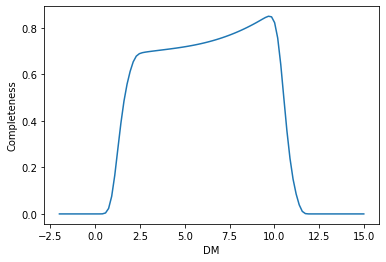

In [10]:
compDM = df_comp["compDM"].to_numpy()
DM = df_comp["DM"].to_numpy()

# plot
plt.plot(DM, compDM)
plt.xlabel("DM")
plt.ylabel("Completeness")
plt.show()


In [11]:
# interpolate compDM, set to 0 if beyong the range
compDM_interp = interpolate.interp1d(DM, compDM, fill_value=0, bounds_error=False)

compDM_interp(-20)

array(0.)

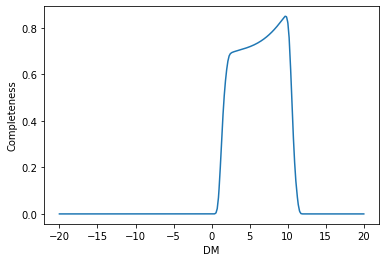

In [12]:
dms = np.linspace(-20, 20, 1000)
compDMs = compDM_interp(dms)

# plot
plt.plot(dms, compDMs)
plt.xlabel("DM")
plt.ylabel("Completeness")
plt.show()

In [13]:
Z = 200
R = 150

In [14]:
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 1000) #edges
er = np.linspace(0, R, 1000)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2

dz = ez[1]-ez[0]

In [15]:
from tqdm import tqdm

frac = []
for zz in tqdm(z):
    real_vol = 0
    eff_vol = 0
    for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
        glat = np.arctan(zz/rr)
        dv = np.pi*(r_out**2-r_in**2)*dz
        real_vol += dv
        distance =np.sqrt(rr**2+zz**2)
        dm = 5*np.log10(distance)-5
        if distance>50:
            eff_vol += dv*compDM_interp(dm)
    frac.append(eff_vol/real_vol)


100%|██████████| 999/999 [00:21<00:00, 46.00it/s]


(0.0, 1.0)

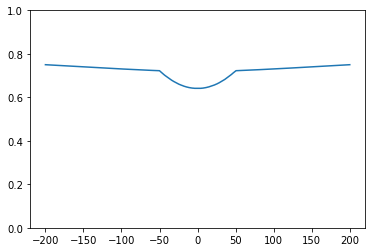

In [16]:
plt.plot(z, frac)
plt.ylim(0,1)

In [17]:
compz = interpolate.interp1d(z, frac, fill_value='interpolate', bounds_error=False)

In [18]:
gaia_raw = vaex.open(join(spectral_dir, name))
gaia = gaia_raw.filter("Dist>50")
gaia = gaia.extract()
gaia

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,GLON,GLAT,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,spectraltype_esphs,subclass_lamost,rv,e_rv,rv_cat,teff,e_teff_lower,e_teff_upper,teff_symmetric,teff_cat,logg,e_logg_lower,e_logg_upper,logg_symmetric,logg_cat,mh,e_mh_lower,e_mh_upper,mh_symmetric,mh_cat,alphafe,e_alphafe_lower,e_alphafe_upper,alphafe_symmetric,alphafe_cat,fem,e_fem_lower,e_fem_upper,fem_symmetric,fem_cat,feh,e_feh_lower,e_feh_upper,feh_symmetric,feh_cat,JK,M_J,Dist,z,r,pmlon,pmlat,e_pmlon,e_pmlat,vb,vphi,e_vb,e_vphi,w,e_w,v_xy,e_v_xy,v,e_v,u,e_u,M_J_lower,M_J_upper
0,0.0071074868596039875,-1.2273890258172142,8.69,8.393,AAA,4702959678401321984,37.18967,23.58711228133474,0.011803952,-28.752733940266236,0.014449707,8.74803741556182,0.012488439,9.653302,9.947792,9.193761,2110.065,3865.7065,0.9105442,1.1956643,2.2506821387235147,-0.8066398204825131,114.0146,113.8348,114.2071,0.0009,0.0002,0.0024,G,--,24.771608352661133,0.21023516356945038,gaia,5889.33837890625,1.6259765625,2.79736328125,0.0,gspphot,4.333700180053711,0.0020003318786621094,0.00189971923828125,0.0,gspphot,-0.0892999991774559,0.004799999296665192,0.00469999760389328,0.0,gspphot,0.09000000357627869,0.01000000536441803,0.019999995827674866,0.0,gspspec,-0.05000000074505806,0.12000000104308128,0.10999999940395355,0.0,gspspec,-0.05000000074505806,nan,nan,nan,--,0.29699993,3.399552739669738,114.31135379246405,-82.528939581882,79.0952573632323,-30.63629306822048,21.082910658875736,0.012028147818888,0.014263624470926195,11.423476121089848,-16.599840883743973,0.018046473993364308,-0.024577299313449357,-9.98003914268823,0.15229546180753484,25.38754036485519,0.14604996247002744,-28.87002922881429,0.09379022174407457,-9.306091310006478,0.11462124359924132,2.064676320139858,3.699086377728994
1,0.00791300866927693,-1.1886556144061122,8.054,7.768,AAA,4706617135111506560,106.13522,100.67758019494745,0.012745832,-33.59629691075584,0.014617821,8.819245685888635,0.012825272,8.921438,9.180581,8.495281,3601.6267,3582.2659,0.9535825,1.1944996,2.2664012719438675,-0.8438796719698852,113.1283,112.9641,113.3001,0.0003,0.0,0.0009,F,--,19.271310806274414,0.16453170776367188,gaia,6096.86279296875,0.89697265625,1.1884765625,0.0,gspphot,4.19290018081665,0.0011000633239746094,0.0010995864868164062,0.0,gspphot,-0.36820000410079956,0.005499988794326782,0.006400018930435181,0.0,gspphot,0.10000000149011612,0.009999997913837433,0.009999997913837433,1.0,gspspec,-0.14000000059604645,0.09000000357627869,0.08999999985098839,0.0,gspspec,-0.14000000059604645,nan,nan,nan,--,0.28599977,2.7811571073922536,113.38838213794915,-84.72686585471331,75.35438544835331,-106.08668463497176,3.2096204114788094,0.01291109978423198,0.014472057033830055,1.725045575581629,-57.017448326035435,0.008172701711885723,-0.08320673474276741,-13.253633114555047,0.12306245528207835,14.096113354206281,0.1095130495093998,-52.80385936873043,0.09489704128019832,25.718519807214676,0.09955410727672585,2.000691585597804,3.5652003459407338
2,0.007857262852968231,-1.1758463463197528,9.192,8.912,AAA,4707461491322117120,13.345008,-3.7093527139682143,0.012067092,-12.819123755569056,0.014386047,5.6572218013616835,0.013139882,10.036402,10.301628,9.610582,2308.2336,5205.91,0.89859104,1.1911147,2.2720671888182924,-0.8561316222271664,176.1877,175.7733,176.5728,0.0068,0.0019,0.0118,F,--,5.5999016761779785,0.2500467300415039,gaia,6095.1259765625,9.75927734375,9.71484375,0.0,gspphot,4.193299770355225,0.004499912261962891,0.004900455474853516,0.0,gspphot,-0.17170000076293945,0.009100005030632019,0.009000003337860107,0.0,gspphot,0.17000000178813934,0.030000001192092896,0.08999998867511749,0.0,gspspec,-0.15000000596046448,0.12999999523162842,0.1300000064074993,0.0,gspspec,-0.15000000596046448,nan,nan,nan,--,0.2800007,2.955016420877087,176.7652100469707,-133.5130653894166,115.845590564

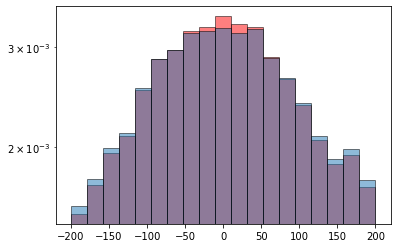

In [19]:
zedge = np.linspace(-Z, Z, 20) #edges
zmid = (zedge[:-1]+zedge[1:])/2
zs = gaia["z"].to_numpy()
znum, _ = np.histogram(zs, bins=zedge)
zcor = znum/compz(zmid)

zs = gaia_raw["z"].to_numpy()
znum_raw, _ = np.histogram(zs, bins=zedge)

dz = zedge[1]-zedge[0]
plt.bar(zmid, zcor/(zcor.sum()*dz), width=dz, edgecolor="k", alpha=0.5, color="r")
plt.bar(zmid, znum_raw/(znum_raw.sum()*dz), width=dz, edgecolor="k", alpha=0.5)
plt.yscale("log")


# automate

In [20]:
files

['/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/gaia_(0.37)_(0.40).hdf5']

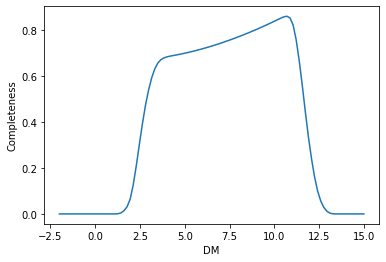

100%|██████████| 999/999 [00:22<00:00, 44.98it/s]


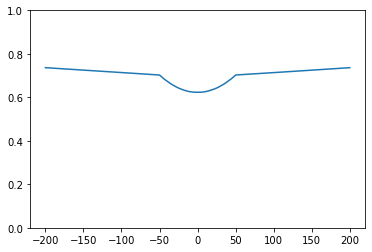

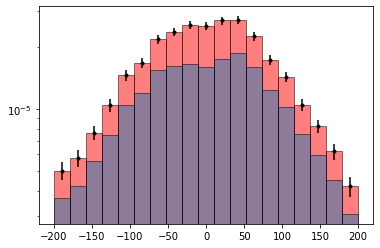

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 

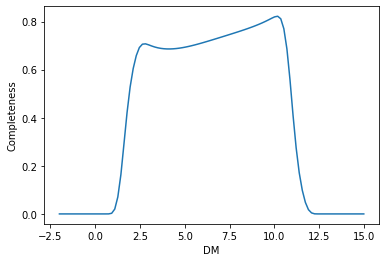

100%|██████████| 999/999 [00:22<00:00, 45.27it/s]


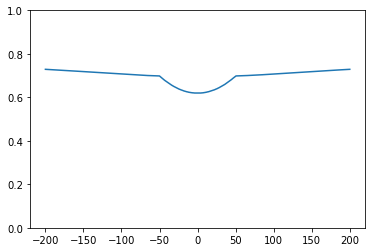

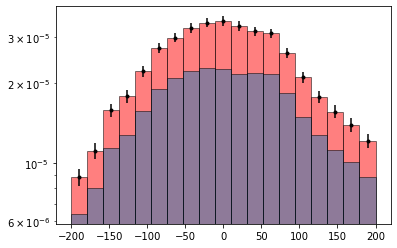

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 

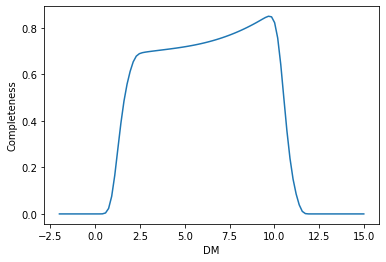

100%|██████████| 999/999 [00:22<00:00, 45.27it/s]


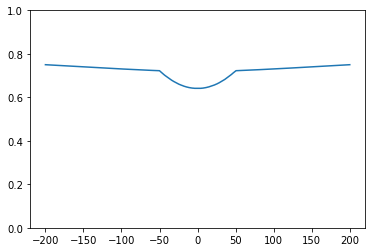

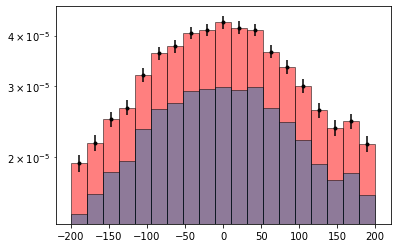

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 

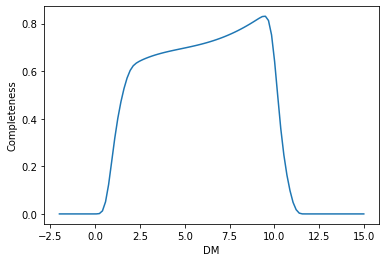

100%|██████████| 999/999 [00:21<00:00, 45.65it/s]


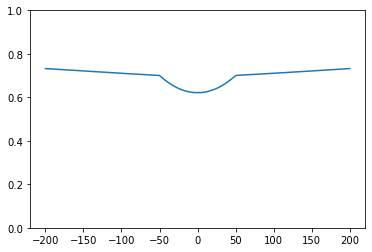

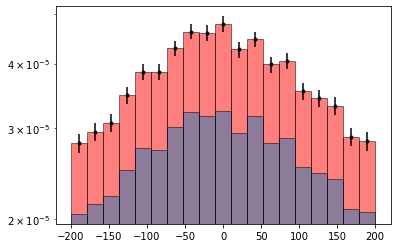

export(hdf5) [########################################] 100.00% elapsed time  :     0.03s =  0.0m =  0.0h
 

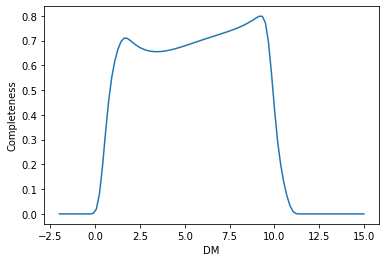

100%|██████████| 999/999 [00:22<00:00, 44.95it/s]


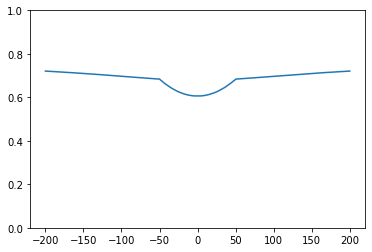

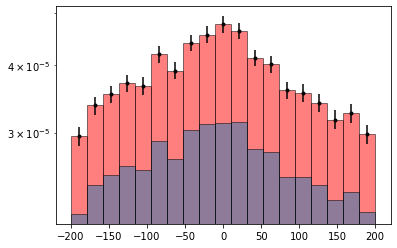

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 

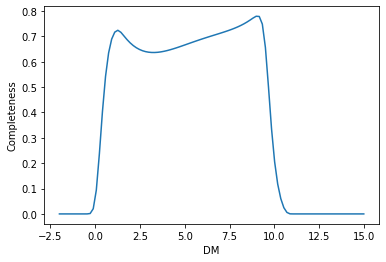

100%|██████████| 999/999 [00:22<00:00, 45.30it/s]


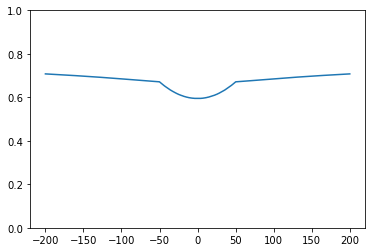

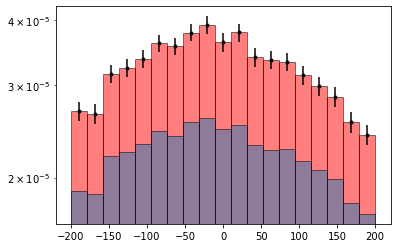

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 

In [22]:
Z = 200
R = 150
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 1000) #edges
er = np.linspace(0, R, 1000)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2

dz = ez[1]-ez[0]

for file in files:
    name = file.split("/")[-1]

    df_comp = vaex.open(join(comp_dir, name))

    compDM = df_comp["compDM"].to_numpy()
    DM = df_comp["DM"].to_numpy()

    # plot
    plt.plot(DM, compDM)
    plt.xlabel("DM")
    plt.ylabel("Completeness")
    plt.show()

    # interpolate compDM, set to 0 if beyong the range
    compDM_interp = interpolate.interp1d(DM, compDM, fill_value=0, bounds_error=False)

    frac = []
    for zz in tqdm(z):
        real_vol = 0
        eff_vol = 0
        for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
            glat = np.arctan(zz/rr)
            dv = np.pi*(r_out**2-r_in**2)*dz
            real_vol += dv
            distance =np.sqrt(rr**2+zz**2)
            dm = 5*np.log10(distance)-5
            if distance>50:
                eff_vol += dv*compDM_interp(dm)
        frac.append(eff_vol/real_vol)

    plt.plot(z, frac)
    plt.ylim(0,1)
    plt.show()

    compz = interpolate.interp1d(z, frac, fill_value='interpolate', bounds_error=False)

    gaia_raw = vaex.open(join(spectral_dir, name))
    gaia = gaia_raw.filter("Dist>50")
    gaia = gaia.extract()
    gaia

    zedge = np.linspace(-Z, Z, 20) #edges
    zmid = (zedge[:-1]+zedge[1:])/2
    zs = gaia["z"].to_numpy()
    vol = np.pi*(R**2)*(2*Z)
    znum, _ = np.histogram(zs, bins=zedge)
    density = znum/(compz(zmid)*vol)
    
    density_err = density/np.sqrt(znum)
    zs = gaia_raw["z"].to_numpy()
    znum_raw, _ = np.histogram(zs, bins=zedge)
    density_raw = znum_raw/vol

    dz = zedge[1]-zedge[0]
    plt.bar(zmid, density, width=dz, edgecolor="k", alpha=0.5, color="r")
    plt.bar(zmid, density_raw, width=dz, edgecolor="k", alpha=0.5)
    plt.errorbar(zmid, density, yerr=density_err, fmt=".", color="k")
    plt.yscale("log")
    plt.show()
    df = vaex.from_arrays(z=zmid, density_corr=density, density=density_raw, density_err=density_err)
    df.export(join(data_dir, name), progress=True)
